# CNN Model


In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 requires 299x299 input
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

class SculptureDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_paths = glob.glob(f"{img_dir}/*.png")
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, img_path  # Return image + filename for tracking

# Load dataset
dataset = SculptureDataset("processed_images", transform=transform)

# Split dataset (80% train, 10% val, 10% test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained InceptionV3
model = models.inception_v3(pretrained=True)

# Remove classification head and use Global Average Pooling (GAP)
model.fc = nn.Identity()  # Replace final FC layer with identity function

# Freeze all layers to use as a feature extractor
for param in model.parameters():
    param.requires_grad = False

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)  # Check architecture


C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|███████████████████████████████████████████████████████████████████████████████| 104M/104M [00:50<00:00, 2.16MB/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
import torch
import numpy as np
import os

# Directory to save extracted features
FEATURES_DIR = "extracted_features"
os.makedirs(FEATURES_DIR, exist_ok=True)

def extract_features(dataloader, split_name):
    """Extract and save features for train/val/test dataset."""
    model.eval()
    features = []
    filenames = []

    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(device)
            outputs = model(images)  # Get feature vectors
            outputs = outputs.cpu().numpy()

            features.extend(outputs)
            filenames.extend(img_paths)

    # Convert to numpy array
    features = np.array(features)

    # Save features
    np.save(os.path.join(FEATURES_DIR, f"{split_name}_features.npy"), features)
    np.save(os.path.join(FEATURES_DIR, f"{split_name}_filenames.npy"), filenames)
    print(f"Saved {split_name} features to {FEATURES_DIR}")

# Extract features for train, val, and test sets
extract_features(train_loader, "train")
extract_features(val_loader, "val")
extract_features(test_loader, "test")


Saved train features to extracted_features
Saved val features to extracted_features
Saved test features to extracted_features


In [4]:
import numpy as np
import os

FEATURES_DIR = "extracted_features"

# Function to load and print sample features
def print_extracted_features(split_name):
    features_path = os.path.join(FEATURES_DIR, f"{split_name}_features.npy")
    filenames_path = os.path.join(FEATURES_DIR, f"{split_name}_filenames.npy")

    # Load features and filenames
    features = np.load(features_path)
    filenames = np.load(filenames_path, allow_pickle=True)

    # Print the shape of features
    print(f"\n🔹 {split_name.capitalize()} Features Shape: {features.shape}")

    # Print sample extracted features
    print("\n🔍 Sample Extracted Features:")
    for i in range(min(3, len(features))):  # Print first 3 feature vectors
        print(f"🖼️ Image: {filenames[i]}")
        print(f"🔢 Feature Vector (first 5 values): {features[i][:5]}")  # Print first 5 values of the feature vector
        print("-" * 50)

# Print features for train, val, and test sets
print_extracted_features("train")
print_extracted_features("val")
print_extracted_features("test")



🔹 Train Features Shape: (1900, 2048)

🔍 Sample Extracted Features:
🖼️ Image: processed_images\Crowned Buddha_rot270.png
🔢 Feature Vector (first 5 values): [0.48687    0.18151787 0.16525947 0.26991278 0.38228637]
--------------------------------------------------
🖼️ Image: processed_images\Yakshi_aug_2.png
🔢 Feature Vector (first 5 values): [0.19208118 0.01013739 0.6135095  1.4993948  0.07394942]
--------------------------------------------------
🖼️ Image: processed_images\Fragment of a lion capital_rot90.png
🔢 Feature Vector (first 5 values): [1.0139743  0.06117134 0.41563597 0.6986664  0.05269792]
--------------------------------------------------

🔹 Val Features Shape: (237, 2048)

🔍 Sample Extracted Features:
🖼️ Image: processed_images\Female bust_rot180.png
🔢 Feature Vector (first 5 values): [0.08591879 0.09361719 0.7445395  0.8257006  0.32809535]
--------------------------------------------------
🖼️ Image: processed_images\Nandi_1_rot180.png
🔢 Feature Vector (first 5 values): [0.

Shape: (1900, 2048)


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


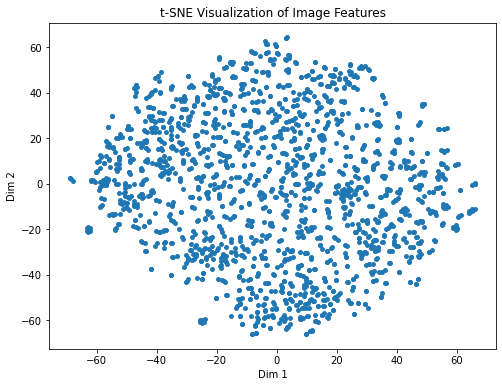

In [5]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load image feature vectors
X_img = np.load("extracted_features/train_features.npy")  # or val/test
print("Shape:", X_img.shape)

# Optional: Use PCA before t-SNE to reduce dimensionality from 2048 -> 50
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_img)

# Now t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=15, cmap="viridis")
plt.title("t-SNE Visualization of Image Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


# Metadata Feature Extraction


In [2]:
# 1. Load CSV
df = pd.read_csv("metadata_final_updated.csv")

# 2. Useful Metadata Columns
metadata_features = [
    'Main Material', 'Context', 'Material & Technique', 'Geographic Context',
    'Cultural Context', 'Gallery Name', 'Object Type', 'Museum Name', 'Classification'
]

# 3. Clean Target Column for Regression
# Remove rows where 'Numeric Date' is not a number
df = df[df['Numeric Date'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
df['Numeric Date'] = df['Numeric Date'].astype(float)

# 4. Clean Metadata Columns
df[metadata_features] = df[metadata_features].fillna("Unknown")
for col in metadata_features:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

# 5. Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_metadata = scaler.fit_transform(df[metadata_features])

# 6. Extract Target
y_reg = df['Numeric Date'].values

# 7. Optional: Train/Test Split
from sklearn.model_selection import train_test_split
X_meta_train, X_meta_test, y_train, y_test = train_test_split(X_metadata, y_reg, test_size=0.2, random_state=42)

# Save if needed
import numpy as np
np.save("X_metadata_scaled.npy", X_metadata)
np.save("y_regression.npy", y_reg)

print("✅ Cleaned and converted metadata and target for regression.")


✅ Cleaned and converted metadata and target for regression.


In [3]:
import pandas as pd
import numpy as np

# Load if you already saved it earlier
X_metadata = np.load("X_metadata_scaled.npy")

# Convert to DataFrame for easy display
metadata_df = pd.DataFrame(X_metadata, columns=[
    'Main Material', 'Context', 'Material & Technique', 'Geographic Context',
    'Cultural Context', 'Gallery Name', 'Object Type', 'Museum Name', 'Classification'
])

# Show first 5 rows
print(metadata_df.head())


   Main Material   Context  Material & Technique  Geographic Context  \
0            0.0  0.225543              0.765436            0.217745   
1            0.0  0.225543              0.765436            0.217745   
2            0.0  0.225543              0.765436            0.217745   
3            0.0  0.225543              0.402194            0.217745   
4            0.0  0.225543              0.765436            0.217745   

   Cultural Context  Gallery Name  Object Type  Museum Name  Classification  
0         -0.178162           0.0          0.0          0.0       -0.262263  
1         -0.178162           0.0          0.0          0.0       -0.262263  
2         -0.316317           0.0          0.0          0.0       -0.262263  
3         -0.500523           0.0          0.0          0.0       -0.262263  
4         -1.237347           0.0          0.0          0.0       -0.262263  


In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("metadata_final_updated.csv")

# === Define Metadata Features ===
metadata_features = [
    'Main Material', 'Context', 'Material & Technique', 'Geographic Context',
    'Cultural Context', 'Gallery Name', 'Object Type', 'Museum Name', 'Classification'
]

# === Step 1: Fit and Save LabelEncoders for Each Column ===
label_encoders = {}
df_encoded = df.copy()

for col in metadata_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# === Step 2: Standard Scale Encoded Metadata ===
scaler = StandardScaler()
X_metadata_scaled = scaler.fit_transform(df_encoded[metadata_features])

# === Step 3: Save the Encoders and Scaler ===
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Optional: Save scaled metadata and target for training
np.save("X_metadata_scaled.npy", X_metadata_scaled)
np.save("y_regression.npy", df_encoded['Numeric Date'].values)

print("✅ Saved label_encoders.pkl, scaler.pkl, and scaled metadata features.")


✅ Saved label_encoders.pkl, scaler.pkl, and scaled metadata features.


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_12024\589640953.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


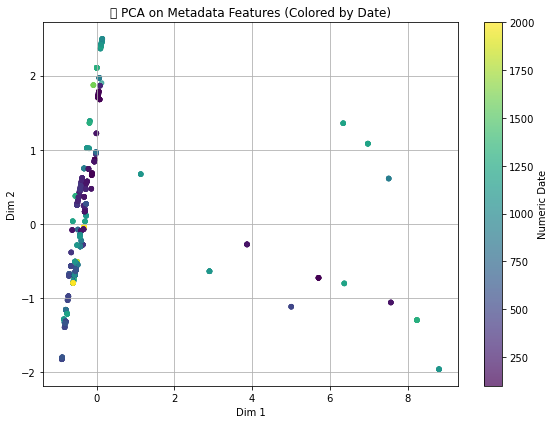

C:\Users\Admin\AppData\Local\Temp\ipykernel_12024\589640953.py:33: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


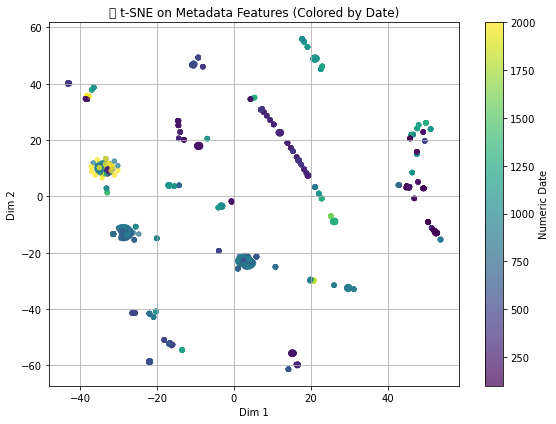

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your preprocessed data
X_metadata = np.load("X_metadata_scaled.npy")
y_reg = np.load("y_regression.npy")

# Optional: For better visualization, sample a subset if dataset is large
# X_metadata = X_metadata[:500]
# y_reg = y_reg[:500]

# ---- PCA ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_metadata)

# ---- t-SNE ----
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_metadata)

# ---- Plotting Helper ----
def plot_embedding(X, y, title):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20, alpha=0.7)
    plt.colorbar(scatter, label="Numeric Date")
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Visualizations ----
plot_embedding(X_pca, y_reg, "📈 PCA on Metadata Features (Colored by Date)")
plot_embedding(X_tsne, y_reg, "🌐 t-SNE on Metadata Features (Colored by Date)")


# Fusion Layer

In [18]:
import numpy as np

# =============================
# Step 1: Load Only Relevant Image Features
# =============================
train_img = np.load("extracted_features/train_features.npy")
val_img = np.load("extracted_features/val_features.npy")
test_img = np.load("extracted_features/test_features.npy")
image_features = np.vstack([train_img, val_img, test_img])
print("Total image features shape:", image_features.shape)

# =============================
# Step 2: Load Metadata Features and Targets
# =============================
metadata_features = np.load("X_metadata_scaled.npy")  # shape: (1562, 9)
targets = np.load("y_regression.npy")  # shape: (1562,)
print("Metadata shape:", metadata_features.shape)
print("Targets shape:", targets.shape)

# =============================
# Step 3: Truncate Image Features to Match Metadata Count
# =============================
image_features = image_features[:metadata_features.shape[0]]
print("Trimmed image features shape:", image_features.shape)

# =============================
# Step 4: Concatenate
# =============================
fused_features = np.hstack([image_features, metadata_features])
print("Fused features shape:", fused_features.shape)

# =============================
# Step 5: Save
# =============================
np.save("fused_features.npy", fused_features)
print("✅ Fused features saved as 'fused_features.npy'")


Total image features shape: (2376, 2048)
Metadata shape: (1562, 9)
Targets shape: (1562,)
Trimmed image features shape: (1562, 2048)
Fused features shape: (1562, 2057)
✅ Fused features saved as 'fused_features.npy'


Epoch 1/50 | Val RMSE: 525.19
Epoch 2/50 | Val RMSE: 469.87
Epoch 3/50 | Val RMSE: 495.36
Epoch 4/50 | Val RMSE: 426.32
Epoch 5/50 | Val RMSE: 383.53
Epoch 6/50 | Val RMSE: 416.45
Epoch 7/50 | Val RMSE: 368.09
Epoch 8/50 | Val RMSE: 360.95
Epoch 9/50 | Val RMSE: 496.30
Epoch 10/50 | Val RMSE: 389.43
Epoch 11/50 | Val RMSE: 382.92
Epoch 12/50 | Val RMSE: 352.67
Epoch 13/50 | Val RMSE: 379.57
Epoch 14/50 | Val RMSE: 423.50
Epoch 15/50 | Val RMSE: 619.61
Epoch 16/50 | Val RMSE: 355.92
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
Epoch 17/50 | Val RMSE: 342.99
Epoch 18/50 | Val RMSE: 342.14
Epoch 19/50 | Val RMSE: 348.16
Epoch 20/50 | Val RMSE: 490.95
Epoch 21/50 | Val RMSE: 429.08
Epoch 22/50 | Val RMSE: 411.09
Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.
Epoch 23/50 | Val RMSE: 383.29
Epoch 24/50 | Val RMSE: 349.50
Epoch 25/50 | Val RMSE: 350.90
Early stopping triggered.

Test Results:
Regression -> RMSE: 354.16, MAE: 244.59, R^2: 0.20
Classification -> 

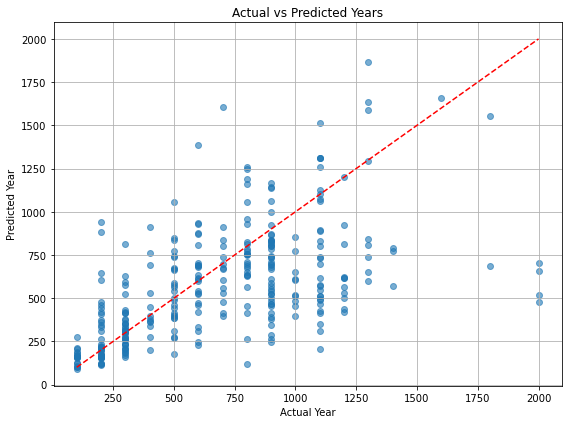

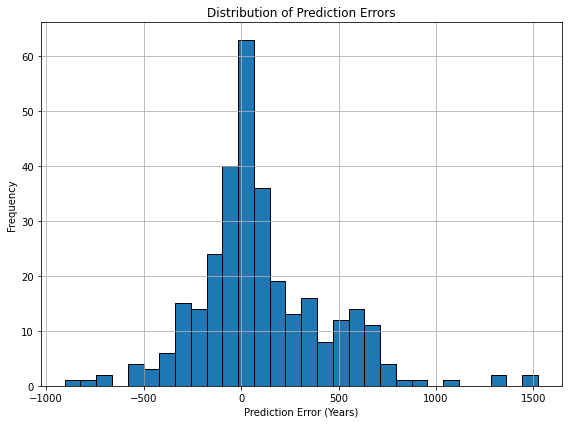

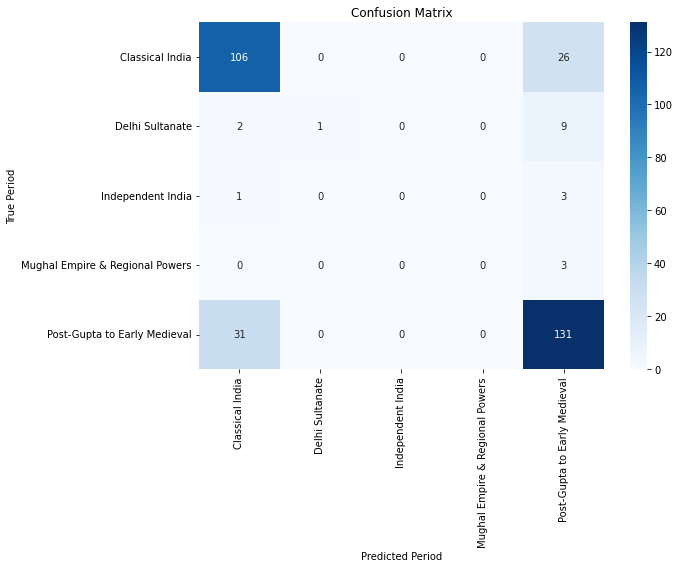

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ========== Load Data ==========
image_features = np.load("extracted_features/train_features.npy")
metadata_features = np.load("X_metadata_scaled.npy")
targets = np.load("y_regression.npy")

# ========== Ensure Same Length ==========
min_len = min(len(image_features), len(metadata_features), len(targets))
image_features = image_features[:min_len]
metadata_features = metadata_features[:min_len]
targets = targets[:min_len]
targets_log = np.log1p(targets)

# ========== Period Mapping ==========
def map_period(year):
    if year < -3000:
        return "Prehistoric India"
    elif -3000 <= year < -600:
        return "Ancient Civilizations"
    elif -600 <= year < -320:
        return "Mahajanapadas & Early Empires"
    elif -320 <= year < 550:
        return "Classical India"
    elif 550 <= year < 1206:
        return "Post-Gupta to Early Medieval"
    elif 1206 <= year < 1526:
        return "Delhi Sultanate"
    elif 1526 <= year < 1857:
        return "Mughal Empire & Regional Powers"
    elif 1857 <= year < 1947:
        return "British Period"
    else:
        return "Independent India"

period_labels = [map_period(yr) for yr in targets]
label_encoder = LabelEncoder()
y_class = label_encoder.fit_transform(period_labels)

# ========== Train/Val/Test Split ==========
X_img_trainval, X_img_test, X_meta_trainval, X_meta_test, y_trainval_log, y_test_log, y_trainval_class, y_test_class = train_test_split(
    image_features, metadata_features, targets_log, y_class, test_size=0.2, random_state=42)

X_img_train, X_img_val, X_meta_train, X_meta_val, y_train_log, y_val_log, y_train_class, y_val_class = train_test_split(
    X_img_trainval, X_meta_trainval, y_trainval_log, y_trainval_class, test_size=0.2, random_state=42)

# ========== Convert to Tensors ==========
def to_tensor(x): return torch.tensor(x, dtype=torch.float32)

torch.manual_seed(42)
X_img_train_tensor = to_tensor(X_img_train)
X_img_val_tensor = to_tensor(X_img_val)
X_img_test_tensor = to_tensor(X_img_test)

X_meta_train_tensor = to_tensor(X_meta_train)
X_meta_val_tensor = to_tensor(X_meta_val)
X_meta_test_tensor = to_tensor(X_meta_test)

y_train_tensor = to_tensor(y_train_log).view(-1, 1)
y_val_tensor = to_tensor(y_val_log).view(-1, 1)
y_test_tensor = to_tensor(y_test_log).view(-1, 1)

train_class_tensor = torch.tensor(y_train_class, dtype=torch.long)
val_class_tensor = torch.tensor(y_val_class, dtype=torch.long)
test_class_tensor = torch.tensor(y_test_class, dtype=torch.long)

# ========== Dataset & Dataloaders ==========
batch_size = 32
train_dataset = TensorDataset(X_img_train_tensor, X_meta_train_tensor, y_train_tensor, train_class_tensor)
val_dataset = TensorDataset(X_img_val_tensor, X_meta_val_tensor, y_val_tensor, val_class_tensor)
test_dataset = TensorDataset(X_img_test_tensor, X_meta_test_tensor, y_test_tensor, test_class_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ========== Model Definition ==========
class FusionMultiTaskModel(nn.Module):
    def __init__(self, img_dim, meta_dim, hidden_dim, num_classes):
        super().__init__()
        self.img_fc = nn.Linear(img_dim, hidden_dim)
        self.meta_fc = nn.Linear(meta_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.shared = nn.Linear(hidden_dim * 2, hidden_dim)
        self.reg_head = nn.Linear(hidden_dim, 1)
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, img_feat, meta_feat):
        x1 = self.relu(self.img_fc(img_feat))
        x2 = self.relu(self.meta_fc(meta_feat))
        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(self.relu(self.shared(x)))
        return self.reg_head(x), self.cls_head(x)

# ========== Training Setup ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionMultiTaskModel(2048, X_meta_train.shape[1], 256, len(label_encoder.classes_)).to(device)

reg_criterion = nn.MSELoss()
cls_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# ========== Training Loop ==========
best_rmse = float('inf')
patience, counter = 7, 0

for epoch in range(1, 51):
    model.train()
    for img, meta, y_reg, y_cls in train_loader:
        img, meta, y_reg, y_cls = img.to(device), meta.to(device), y_reg.to(device), y_cls.to(device)
        optimizer.zero_grad()
        out_reg, out_cls = model(img, meta)
        loss = reg_criterion(out_reg, y_reg) + cls_criterion(out_cls, y_cls)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds_reg, val_targets_reg, val_preds_cls, val_targets_cls = [], [], [], []
    with torch.no_grad():
        for img, meta, y_reg, y_cls in val_loader:
            img, meta = img.to(device), meta.to(device)
            out_reg, out_cls = model(img, meta)
            val_preds_reg.extend(out_reg.cpu().squeeze().numpy())
            val_targets_reg.extend(y_reg.squeeze().numpy())
            val_preds_cls.extend(torch.argmax(out_cls, dim=1).cpu().numpy())
            val_targets_cls.extend(y_cls.numpy())

    val_rmse = mean_squared_error(np.expm1(val_targets_reg), np.expm1(val_preds_reg), squared=False)
    print(f"Epoch {epoch}/50 | Val RMSE: {val_rmse:.2f}")

    scheduler.step(val_rmse)

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# ========== Load Best Model ==========
model.load_state_dict(best_model)

# ========== Test Evaluation ==========
model.eval()
test_preds_reg, test_targets_reg, test_preds_cls, test_targets_cls = [], [], [], []
with torch.no_grad():
    for img, meta, y_reg, y_cls in test_loader:
        img, meta = img.to(device), meta.to(device)
        out_reg, out_cls = model(img, meta)
        test_preds_reg.extend(out_reg.cpu().squeeze().numpy())
        test_targets_reg.extend(y_reg.squeeze().numpy())
        test_preds_cls.extend(torch.argmax(out_cls, dim=1).cpu().numpy())
        test_targets_cls.extend(y_cls.numpy())

# Regression metrics
test_preds_years = np.expm1(test_preds_reg)
test_targets_years = np.expm1(test_targets_reg)
rmse = mean_squared_error(test_targets_years, test_preds_years, squared=False)
mae = mean_absolute_error(test_targets_years, test_preds_years)
r2 = r2_score(test_targets_years, test_preds_years)

# Classification metrics
acc = accuracy_score(test_targets_cls, test_preds_cls)
conf_mat = confusion_matrix(test_targets_cls, test_preds_cls)

print(f"\nTest Results:")
print(f"Regression -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R^2: {r2:.2f}")
print(f"Classification -> Accuracy: {acc:.2f}")
print("Confusion Matrix:\n", conf_mat)

# ========== Visualizations ==========
plt.figure(figsize=(8, 6))
plt.scatter(test_targets_years, test_preds_years, alpha=0.6)
plt.plot([min(test_targets_years), max(test_targets_years)], [min(test_targets_years), max(test_targets_years)], 'r--')
plt.xlabel("Actual Year")
plt.ylabel("Predicted Year")
plt.title("Actual vs Predicted Years")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(test_targets_years - test_preds_years, bins=30, edgecolor='black')
plt.xlabel("Prediction Error (Years)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted Period")
plt.ylabel("True Period")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

torch.save(best_model, "fusion_model.pth")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
